In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from books_functions import *

In [2]:
#set inputs
file_name_ratings='BX-Book-Ratings.csv'
file_name_books='BX-Books.csv'
file_name_users='BX-Users.csv'

In [3]:
#get the encoding
with open(file_name_users) as file: 
    enc=file.encoding
    print(enc) 

cp1252


**Read USER file**

In [4]:
users = pd.read_csv(file_name_users, encoding=enc, delimiter=';')
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


**Read RATINGS file**

In [5]:
ratings = pd.read_csv(file_name_ratings, encoding=enc, delimiter=';')
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [6]:
#rename columns
ratings=ratings.rename(columns={'User-ID': 'user',
                                'ISBN': 'isbn',
                                'Book-Rating':'rating'})
ratings.head(3)


ratings.shape


(1149780, 3)

In [7]:
titles_count_before=len(ratings.groupby(['isbn']))
titles_count_before

340556

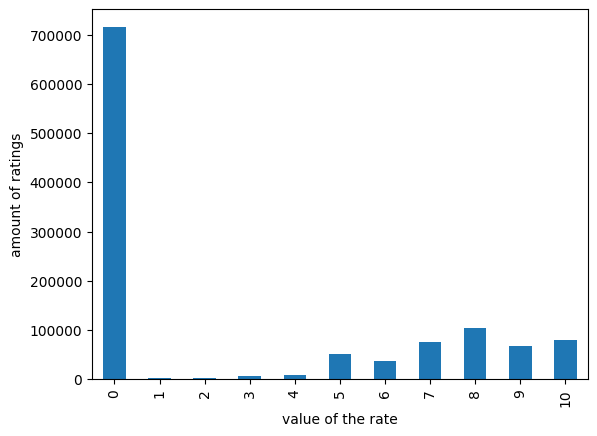

In [8]:
#check if there are some ratings out of scale 0-10

chart=(ratings['rating'].value_counts()
                        .sort_index()      
)

#Call the function
bar_chart(chart, x_label='value of the rate', y_label='amount of ratings')

In [9]:
#filter out those with zero - justify it !!!
ratings=ratings.query('rating >4')

ratings.shape[0]


414242

In [10]:
titles_count_after=len(ratings.groupby(['isbn']))
print(titles_count_after)

delta=(titles_count_before-titles_count_after)

loss_percentage=(round(delta/titles_count_before*100))
print(f'unique title loss: {loss_percentage}%')

179376
unique title loss: 47%


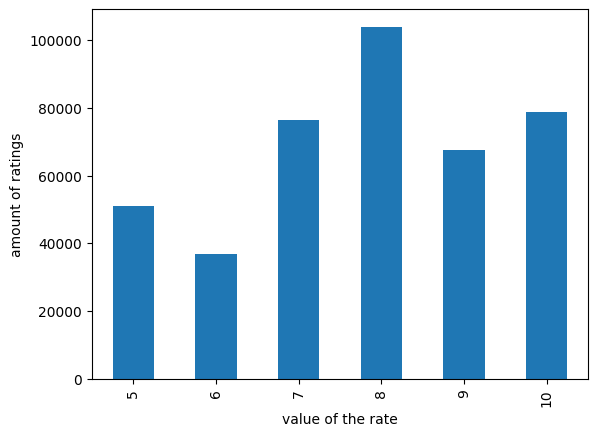

In [11]:
#check if there are some ratings out of scale 0-10

chart=(ratings['rating'].value_counts()
                        .sort_index()      
)

#Call the function
bar_chart(chart, x_label='value of the rate', y_label='amount of ratings')

In [12]:
#number of ratings from users
ratings_per_user=pd.DataFrame()
ratings_per_user['ratings per user'] = ratings['user'].value_counts()


#Reset the index and drop it after reseting
ratings_per_user=(ratings_per_user.reset_index()
             .sort_values('ratings per user',ascending=False)
)


#get the first column name
first_column_name=ratings_per_user.columns[0]

ratings_per_user=ratings_per_user.rename(columns=({first_column_name:'user id'}))

ratings_per_user.head(10)

,user id,ratings per user
0,11676,7768
1,98391,5802
2,153662,1958
3,189835,1901
4,23902,1375
5,171118,1020
6,235105,1014
7,76499,994
8,16795,944
9,56399,911


In [13]:
#this helps to determine how much should I slice the df

users_and_ratings=(ratings_per_user.groupby(['ratings per user'])
                .agg({'user id':'count'})
                .reset_index()
                .rename(columns=({'user id':'number of users'}))
                )  

users_and_ratings.head(5)

,ratings per user,number of users
0,1,43929
1,2,9588
2,3,4988
3,4,3031
4,5,2150


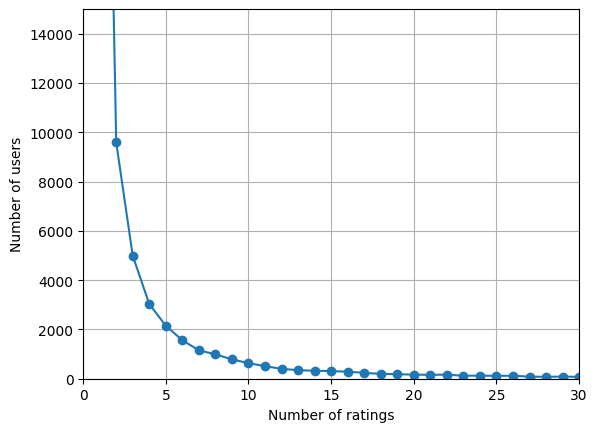

In [14]:
#plot the chart
curve_chart(df=users_and_ratings, 
            x_col='ratings per user',
            y_col='number of users',
            x_lim=30, 
            y_lim=15000, 
            x_label='Number of ratings', 
            y_label='Number of users'
            )


In [15]:
#Filter out the ids of users who did at least 200 ratings
#I need users who had more than 1 rating = otherwise there would be no recommendation from them on ther titles

ratings_per_user_sliced=ratings_per_user.query('`ratings per user` >10')

In [16]:
#how much data will I loose after slice??? - count it!!!
users_before=ratings_per_user.shape[0]
print(f'before: {users_before}')

users_after=ratings_per_user_sliced.shape[0]

delta=users_before-users_after

print(f'after: {users_after}')
print(f'lost users: {round(delta/users_before*100)}%')

before: 75117
after: 6312
lost users: 92%


In [17]:
#convert filtered data into a list
best_users = ratings_per_user_sliced['user id'].tolist()
len(best_users)

6312

In [18]:
#choose just the ids from the list=those who have > 1 rating
ratings_filter=(ratings.query('user in @best_users')
       .reset_index(drop=True)
       .rename(columns={'user':'best users'})
)

ratings_filter.head(2)

,best users,isbn,rating
0,276822,0060096195,10
1,276822,0141310340,9


**Read BOOKS file**

In [19]:
books = pd.read_csv(file_name_books, encoding=enc, delimiter=';', on_bad_lines='skip')

#drop and rename columns
books=(books.drop(['Image-URL-S','Image-URL-L', 'Year-Of-Publication', 'Publisher'], axis=1)
       .rename(columns={'ISBN':'isbn',
                     'Book-Title':'title',
                     'Book-Author':'author'})       
)

books.head(3)

C:\Users\Martin\AppData\Local\Temp\ipykernel_16344\961455818.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(file_name_books, encoding=enc, delimiter=';', on_bad_lines='skip')


,isbn,title,author,Image-URL-M
0,0195153448,Classical Mythology,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,http://images.amazon.com/images/P/0060973129.0...


In [20]:
books.shape

(271360, 4)

**Clean from weird symbols**

In [21]:
#check for special symbols in titles

import re

# Define a regex pattern to match titles with weird symbols
weird_symbols = r'[ÃÂª¶¤@©¿¡µ]' #,Â,¤


# Use query function
titles_with_weird_symbols = books.query('title.str.contains(@weird_symbols)')

# Display the titles with weird symbols
titles_with_weird_symbols.sample(5)

,isbn,title,author,Image-URL-M
162613,2013219830,Ma mÃ?Â¨re m'Ã?Â©puise,Hubert Ben Kemoun,http://images.amazon.com/images/P/2013219830.0...
72509,3455093450,Das Universum in der NuÃ?Â?schale.,Stephen W. Hawking,http://images.amazon.com/images/P/3455093450.0...
14465,3499420694,GefÃ¤hrliche Neugier (Rororo Thriller),HansjÃ¶rg Martin,http://images.amazon.com/images/P/3499420694.0...
25629,8401385350,El Crimen Del Oriente (Ave fÃ©nix),Javier Tomeo,http://images.amazon.com/images/P/8401385350.0...
223285,3440084477,Der Kosmos MondfÃ?Â¼hrer. Mondbeobachtung fÃ?Â...,Jean Lacroux,http://images.amazon.com/images/P/3440084477.0...


In [22]:
#check how many
print(len(titles_with_weird_symbols))

6662


In [23]:
#cut off the weird titles
list_weird_titles=list(titles_with_weird_symbols['title'])


#filter out titles with weird symbols based on the list
books=(books.query('title not in @list_weird_titles')
       .reset_index(drop=True)
       #.rename(columns={'user':'best users'})
)

books.shape

(264698, 4)

**Add to the most active users extra columns**

In [24]:
#reminder previous df
ratings_filter.head(2)

,best users,isbn,rating
0,276822,0060096195,10
1,276822,0141310340,9


In [25]:
#merge 2 dataframes 'ratings-filtered' and 'books'
ratings_filter_merge = ratings_filter.merge(books, on='isbn')
ratings_filter_merge.sample(3)

,best users,isbn,rating,title,author,Image-URL-M
46677,258534,0449221482,9,J Is for Judgment,Sue Grafton,http://images.amazon.com/images/P/0449221482.0...
119141,35783,847600575X,9,La Imaginacion y El Arte En La Infancia,Liev Semionovich Vigotski,http://images.amazon.com/images/P/847600575X.0...
91898,83671,0345338545,9,Follow the River,James Alexander Thom,http://images.amazon.com/images/P/0345338545.0...


In [26]:
#check the loses
before=ratings_filter.shape[0]
after=ratings_filter_merge.shape[0]
delta=before-after

print(before, after, delta)

print(f'percentage loss: {round(delta/before*100)}%')

274573 244608 29965
percentage loss: 11%


**Count how many times was book rated and add this column in previous df**

In [27]:
book_rating_count = (ratings_filter_merge.groupby(['isbn'])
                    .agg({'author': 'count'})
                    .reset_index()
                    .sort_values('author', ascending=False)                 
)

book_rating_count = book_rating_count.reset_index(drop=True)

#rename the column
book_rating_count.rename(columns = {'author':'title-number of ratings'}, inplace=True)
book_rating_count

,isbn,title-number of ratings
0,0316666343,312
1,0385504209,262
2,0312195516,178
3,059035342X,175
4,0142001740,160
...,...,...
114721,0460872974,1
114722,0460872931,1
114723,B000234N3A,1
114724,9627982032,0


In [28]:
#count how many isbns have same amount of ratings
isbn_same_number_rating = (book_rating_count.groupby(['title-number of ratings'])
                    .agg({'isbn': 'count'})
                    .reset_index()
                    .sort_values('title-number of ratings', ascending=False)
                    .rename(columns=({'isbn':'number of books with the same number of ratings'})) 
)

isbn_same_number_rating

,title-number of ratings,number of books with the same number of ratings
122,312,1
121,262,1
120,178,1
119,175,1
118,160,1
...,...,...
4,4,3373
3,3,6323
2,2,16335
1,1,80338


In [29]:
#Add column Book-Rating-Count into main df - using merge
final_df = ratings_filter_merge.merge(book_rating_count, on='isbn')
final_df.sample(5)

,best users,isbn,rating,title,author,Image-URL-M,title-number of ratings
26201,243294,0440147956,10,Light a Penny Candle,Maeve Binchy,http://images.amazon.com/images/P/0440147956.0...,9
89125,16634,0553291165,8,Raising the Stones,Sheri S. Tepper,http://images.amazon.com/images/P/0553291165.0...,2
239941,255218,0881848522,10,Ring Around the Sun (Masters of Science Fiction),Clifford D. Simak,http://images.amazon.com/images/P/0881848522.0...,1
219634,189835,0688115586,5,The Emerald City of Oz (Books of Wonder),L. Frank Baum,http://images.amazon.com/images/P/0688115586.0...,1
43730,259035,0446611085,10,Suzanne's Diary for Nicholas,James Patterson,http://images.amazon.com/images/P/0446611085.0...,35


**Filter out based on number of rates**

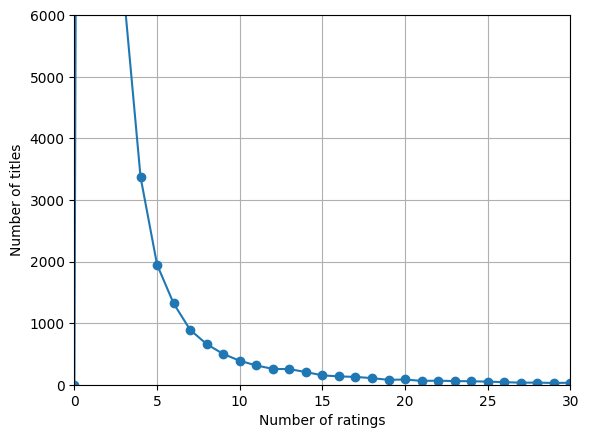

In [30]:
#plot the chart
curve_chart(df=isbn_same_number_rating, 
            x_col='title-number of ratings',
            y_col='number of books with the same number of ratings',
            x_lim=30, 
            y_lim=6000, 
            x_label='Number of ratings', 
            y_label='Number of titles'
)

In [31]:
#filter books with the rating >= 1
#If I kept the rating just 1, I would recommend other books to the same user!!!

final_df_filtered=final_df.query('`title-number of ratings`>10')

final_df_filtered.tail(5)

,best users,isbn,rating,title,author,Image-URL-M,title-number of ratings
187285,184513,0312958129,7,Coming Home,Rosamunde Pilcher,http://images.amazon.com/images/P/0312958129.0...,12
187286,233117,0312958129,10,Coming Home,Rosamunde Pilcher,http://images.amazon.com/images/P/0312958129.0...,12
187287,245645,0312958129,10,Coming Home,Rosamunde Pilcher,http://images.amazon.com/images/P/0312958129.0...,12
187288,270352,0312958129,6,Coming Home,Rosamunde Pilcher,http://images.amazon.com/images/P/0312958129.0...,12
187289,274301,0312958129,10,Coming Home,Rosamunde Pilcher,http://images.amazon.com/images/P/0312958129.0...,12


In [32]:
before=final_df.shape[0]
after=final_df_filtered.shape[0]
delta=before-after

print(before, after, delta)
print(f'percentage loss: {round(delta/before*100)}%')

244608 61573 183035
percentage loss: 75%


**Check the unique titles and isbn**

In [33]:
unique_isbn_check=final_df_filtered.groupby(['isbn'])
unique_title_check=final_df_filtered.groupby(['title'])


isbn_count=len(unique_isbn_check['isbn'])
title_count=len(unique_title_check['title'])

print(isbn_count,title_count)

2647 2389


In [34]:
#check duplicates user rates on the same isbn more than once
check_duplicates = final_df_filtered[['best users', 'isbn']].duplicated().sum()
check_duplicates

0

**PIVOT TABLE**

In [35]:
final_df_filtered = final_df_filtered.reset_index(drop=True)

recommend_pivot = final_df_filtered.pivot_table(columns='best users', index='title' , values="rating")

# #missing values NaN are replaced by zeros
recommend_pivot.fillna(0, inplace=True)

recommend_pivot.shape

(2389, 5538)

In [36]:
recommend_pivot.head(3)

best users,242,243,254,388,446,503,505,507,638,643,...,278221,278356,278390,278418,278535,278554,278582,278633,278843,278851
title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**--------------------------------------**


**MY APPROACH**


**--------------------------------------**

In [37]:
#rename the pivot table 
pivot_mine = recommend_pivot
pivot_mine.head(2)

best users,242,243,254,388,446,503,505,507,638,643,...,278221,278356,278390,278418,278535,278554,278582,278633,278843,278851
title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#whisper function - get the index of certain book:
index_location=book_index_finder('It', pivot_mine)

The index of 'It' is at location 876.


In [39]:
#choose the searched book=row => columns with those who rated same book
searched_book=pivot_mine.iloc[index_location, :]
searched_book.head(5)

best users
242    0.0
243    0.0
254    0.0
388    0.0
446    0.0
Name: It, dtype: float64

In [40]:
#convert Series into dataframe
same_book_readers=pd.DataFrame({'rating':searched_book})
same_book_readers.head(5)

,rating
best users,
242,0.0
243,0.0
254,0.0
388,0.0
446,0.0


In [41]:
#keep just those who rated > 8, those who liked the book
same_book_readers=same_book_readers.query('rating >= 8').reset_index()
print(same_book_readers.shape)
same_book_readers.head(5)

(41, 2)


,best users,rating
0,4334,8.0
1,11676,8.0
2,16795,8.0
3,31826,10.0
4,32569,10.0


In [42]:
#convert a df into a list
columns_to_keep=same_book_readers['best users'].tolist()
columns_to_keep[0:3]

[4334, 11676, 16795]

In [43]:
#filter the columns
filtered_pivot_table = pivot_mine[columns_to_keep]
filtered_pivot_table.head(3)

best users,4334,11676,16795,31826,32569,32599,35859,37293,43806,53392,...,211426,219683,224764,232106,234597,236283,254206,258534,259901,274061
title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#sum the rows
score=filtered_pivot_table.sum(axis=1)

#create df
df_recommendation = pd.DataFrame({'score':score}).sort_values('score', ascending=False)
df_recommendation.head(15)


,score
title,
It,377.000000
Nightmares &amp; Dreamscapes,120.000000
Misery,120.000000
The Tommyknockers,111.500000
Four Past Midnight,106.000000
Dolores Claiborne,106.000000
Insomnia,103.500000
Desperation,103.000000
Skeleton Crew,100.000000


In [45]:
#slice first 10 best titles                   
df_recommendation=df_recommendation[0:100000]
df_recommendation

,score
title,
It,377.0
Nightmares &amp; Dreamscapes,120.0
Misery,120.0
The Tommyknockers,111.5
Four Past Midnight,106.0
...,...
The Eyre Affair: A Novel,0.0
Jennifer Government : A Novel,0.0
The Face of Deception,0.0


In [46]:
suggestions_mine=df_recommendation.index.tolist()
suggestions_mine[0:15]

['It',
 'Nightmares &amp; Dreamscapes',
 'Misery',
 'The Tommyknockers',
 'Four Past Midnight',
 'Dolores Claiborne',
 'Insomnia',
 'Desperation',
 'Skeleton Crew',
 'Pet Sematary',
 'Rose Madder',
 'Dreamcatcher',
 'The Green Mile',
 'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
 'The Dark Half']

**--------------------------------------**

**KNN**

**--------------------------------------**

In [47]:
#rename the matrix
recommend_pivot_knn = recommend_pivot

#missing values NaN are replaced by zeros
recommend_pivot_knn.fillna(0, inplace=True)

recommend_pivot_knn.shape

(2389, 5538)

In [48]:
#too many zeros in the matrix = computationaly demanding in clustering = CRS matrix = non zero matrix
from scipy.sparse import csr_matrix
recommend_sparse = csr_matrix(recommend_pivot_knn)
recommend_sparse.shape

(2389, 5538)

In [49]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric='cosine', algorithm='brute')
fitted_model=model.fit(recommend_sparse)
fitted_model

NearestNeighbors(algorithm='brute', metric='cosine')

In [50]:
index_location=book_index_finder('Misery', recommend_pivot_knn)

The index of 'Misery' is at location 1063.


In [51]:
#find the nearest
query_point = recommend_pivot_knn.iloc[index_location, :].values.reshape(1, -1)
distances, suggestions = fitted_model.kneighbors(query_point)

In [52]:
query_point.shape

(1, 5538)

In [53]:
suggestions

array([[1063,  857, 1145,  876, 2139]], dtype=int64)

In [54]:
for i in range(len(suggestions)):
        suggestions_knn = list(recommend_pivot_knn.index[suggestions[i]])


suggestions_knn
  

['Misery',
 'Insomnia',
 'Nightmares &amp; Dreamscapes',
 'It',
 'The Tommyknockers']

**--------------------------------------**

**Truncated SVD**

**--------------------------------------**

In [55]:
'''
*reducing the dimensionality
*latent factors=improves recommendation quality
'''

'\n*reducing the dimensionality\n*latent factors=improves recommendation quality\n'

In [56]:
#rename the pivot table
recommend_pivot_svd=recommend_pivot
recommend_pivot_svd.head(3)

best users,242,243,254,388,446,503,505,507,638,643,...,278221,278356,278390,278418,278535,278554,278582,278633,278843,278851
title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
#get the array from the pivot
X=recommend_pivot_svd.values
X.shape

(2389, 5538)

In [58]:
from sklearn.decomposition import TruncatedSVD

SVD=TruncatedSVD(n_components=12, random_state=17)
matrix=SVD.fit_transform(X)
matrix.shape

(2389, 12)

In [59]:
#Compute correlations in the matrix
corr=np.corrcoef(matrix)
corr.shape

(2389, 2389)

In [60]:
index_location=book_index_finder('The Fellowship of the Ring (The Lord of the Rings, Part 1)', recommend_pivot_svd)

The index of 'The Fellowship of the Ring (The Lord of the Rings, Part 1)' is at location 1783.


In [61]:
#pass the index into a corr matrix
corr_index=corr[index_location]

In [62]:
#get all the book titles in the pivot table columns
title=recommend_pivot_svd.index
title.shape


(2389,)

In [63]:
corr_index.shape

(2389,)

In [64]:
#filter the most similar books
suggestion_svd=list(title[(corr_index<1)&(corr_index>0.9)])
suggestion_svd

['Hyperion',
 'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
 'The Hobbit : The Enchanting Prelude to The Lord of the Rings',
 'The Illustrated Man (Grand Master Editions)',
 'The Return of the King (The Lord of the Rings, Part 3)',
 'The Two Towers (The Lord of the Rings, Part 2)']

**Comparing results**

In [65]:
print(suggestions_mine[0:10])

print(suggestions_knn[0:10])

print(suggestion_svd[0:10])


['It', 'Nightmares &amp; Dreamscapes', 'Misery', 'The Tommyknockers', 'Four Past Midnight', 'Dolores Claiborne', 'Insomnia', 'Desperation', 'Skeleton Crew', 'Pet Sematary']
['Misery', 'Insomnia', 'Nightmares &amp; Dreamscapes', 'It', 'The Tommyknockers']
['Hyperion', 'The Fellowship of the Ring (The Lord of the Rings, Part 1)', 'The Hobbit : The Enchanting Prelude to The Lord of the Rings', 'The Illustrated Man (Grand Master Editions)', 'The Return of the King (The Lord of the Rings, Part 3)', 'The Two Towers (The Lord of the Rings, Part 2)']


**EXPORT and LOADING**

In [66]:
#get urls and authors
urls = final_df.drop_duplicates(['title'])

#filter columns
urls=urls[['title', 'Image-URL-M', 'author']]
urls.head(3)

,title,Image-URL-M,author
0,The Boy Next Door,http://images.amazon.com/images/P/0060096195.0...,Meggin Cabot
33,Skin and Other Stories (Now in Speak!),http://images.amazon.com/images/P/0141310340.0...,Roald Dahl
37,Growing Wings,http://images.amazon.com/images/P/0142302198.0...,Laurel Winter


In [67]:
import joblib

#Export model
#joblib.dump(fitted_model, 'model_knn.pkl')

#Export matrix
joblib.dump(pivot_mine, 'pivot_mine.pkl')

#Export pivot table SVD
#joblib.dump(recommend_pivot_svd, 'pivot_table_SVD.pkl')

#Export df
joblib.dump(urls, 'urls.pkl')

#Export pivot table KNN
#joblib.dump(recommend_pivot_knn, 'pivot_table_knn.pkl')


['urls.pkl']

In [68]:
import joblib

df=joblib.load('urls.pkl')
df.head(3)

,title,Image-URL-M,author
0,The Boy Next Door,http://images.amazon.com/images/P/0060096195.0...,Meggin Cabot
33,Skin and Other Stories (Now in Speak!),http://images.amazon.com/images/P/0141310340.0...,Roald Dahl
37,Growing Wings,http://images.amazon.com/images/P/0142302198.0...,Laurel Winter


In [69]:
#feedback:

#use charts that you will use for something x do not use chart without giving you any information
#if you implement method you must know how does it work - limitations - adjust data to it
#how do you measure the success? Try an unknown book and verify that's others read it.
#if you slice it - why? - how much data you will loose?
#zeros and NaN I lost the information about zero ratings in the pivot tables


#everytime you drop or remove or simplify something - you must have prove for that!!!!!


In [70]:
#vzfiltruj knihy ktere maji celkovou sumu hodnoceni - nula = i borec s nulou muze mit dalsi nenulove
#musim rozlisit jak definovat nulu-hodnoceni!!!!!

In [71]:
import re

df=pd.DataFrame({'index':range(0,4),
                 'word':['pokus$ deb#l', 'ho@vno','normal','ko#kot'],
                 'normal column':['ahoj', 'nazdar', 'pokus', 'wow']})


# Define a regex pattern to match titles with weird symbols
pattern = r'[ #$!@#¡¿]'

# Use the str.contains() method to check for titles containing the pattern
titles_with_weird_symbols = df.query('word.str.contains(@pattern)')

# Display the titles with weird symbols
titles_with_weird_symbols


,index,word,normal column
0,0,pokus$ deb#l,ahoj
1,1,ho@vno,nazdar
3,3,ko#kot,wow
